# In preparation

further study:
- understand in details difference between `concat`, `merge`, and related methods in pandas
- in sklearn, how to use preprocessing, pipeline etc

In [1]:
import itertools

import statsmodels
import statsmodels.formula
import statsmodels.formula.api
import pandas as pd
import numpy as np

import scipy, scipy.signal

import sklearn
import sklearn.decomposition
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.model_selection

import matplotlib.pyplot as plt
pd.options.display.max_rows = 100

In [2]:
import re

In [3]:
storepath = "/home/joao/NTDFileReader/futuresnew.h5"

In [4]:
currencies_symbols = ['6A', '6B', "6C", "6E", "6J", "6S"]

In [5]:
with pd.HDFStore(storepath, mode='r') as store:
    all_keys = store.keys()

In [6]:
sn = re.compile(r"/NTD/minute_(?P<symbol>6[ABCEJ])(?P<year>\d\d\d\d)(?P<month>\d\d)$")
#symbol_filter = lambda x: True sn.match(x).groupdict()['year'] if sn.match(x).groupdict()['year'] and sn.match(x).groupdict()['year']== "2010"
def symbol_filter(s):
    m = sn.match(s)
    if m and m.groupdict()['year'] == "2010" and m.groupdict()['month'] == "06":
        return True
    else:
        return False

In [7]:
list_dfs = []

for key in filter(symbol_filter, all_keys):
    contract_name = key[-8:]
    #print(contract_name)
    df = pd.read_hdf(storepath, key)
    s = df['close']
    s.name = contract_name
    list_dfs.append(s)
    
df = pd.concat(list_dfs, axis=1)
df.rename(columns=dict(zip(df.columns,"ABCEJ")), inplace=True)

In [10]:
diffs = df.fillna(method='ffill').diff()
normd = (diffs - diffs.mean())/(diffs.std())
#normd = normd[ ~(normd.abs()>3) ].loc["2010-03-26":"2010-03-29"].dropna(how="any")
#normd = normd[ ~(normd.abs()>4) ].dropna(how="any")
normd.dropna(how="any", inplace=True)

# check that normd is indeed normalized:
assert all(abs(normd.mean()) < 10**-10) and all(abs(normd.std())-1 < 10**-10)

In [11]:
normd.head()

,A,B,C,E,J
timestamp,,,,,
2010-03-08 01:02:00,1.543034,0.001719,0.000218,-1.633071,0.000399
2010-03-08 01:03:00,3.084066,0.001719,0.000218,0.660617,-0.368969
2010-03-08 01:04:00,-2.309548,0.001719,0.000218,-0.322392,0.000399
2010-03-08 01:05:00,0.002001,0.001719,0.000218,0.005277,-0.738337
2010-03-08 01:06:00,-0.383257,2.463591,0.000218,0.332947,0.000399


In [16]:
scaler = sklearn.preprocessing.StandardScaler().fit(df.fillna(method="ffill").diff().dropna())

In [17]:
pca = sklearn.decomposition.PCA()

In [18]:
pca.fit(normd)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
pca.components_

array([[ 0.50441743,  0.4389918 ,  0.47480253,  0.49644762, -0.2845199 ],
       [-0.0471414 ,  0.37353247, -0.07129656,  0.28864012,  0.87741373],
       [ 0.31255442, -0.63813407,  0.58897877, -0.10419822,  0.37059597],
       [-0.51206488,  0.39680791,  0.62722222, -0.4323364 , -0.00325009],
       [-0.61922535, -0.32107334,  0.1708088 ,  0.68735333, -0.10881925]])

In [20]:
pca.explained_variance_ratio_

array([0.54071984, 0.1798338 , 0.12306906, 0.08218057, 0.07419673])

### In the old coordinates the variables have some degree of correlation:

In [21]:
normd.corr()

,A,B,C,E,J
A,1.000000,0.450373,0.592596,0.577818,-0.328245
B,0.450373,1.000000,0.390224,0.574709,-0.176080
C,0.592596,0.390224,1.000000,0.513140,-0.294900
E,0.577818,0.574709,0.513140,1.000000,-0.205094
J,-0.328245,-0.176080,-0.294900,-0.205094,1.000000


### The variables in the new coordinates should be uncorrelated:

In [22]:
pd.DataFrame(pca.transform(normd), index=normd.index, columns=normd.columns).corr()

,A,B,C,E,J
A,1.000000e+00,-7.120743e-15,7.960947e-15,3.633326e-14,-2.211971e-14
B,-7.120743e-15,1.000000e+00,-1.103592e-14,6.575451e-16,4.692908e-15
C,7.960947e-15,-1.103592e-14,1.000000e+00,7.578754e-15,-1.310053e-14
E,3.633326e-14,6.575451e-16,7.578754e-15,1.000000e+00,-5.222380e-15
J,-2.211971e-14,4.692908e-15,-1.310053e-14,-5.222380e-15,1.000000e+00


# Dimensionality reduction

From our test above, 2 PCs explain 72% of variance, 3 PCs explain 84%. Lets start with 2

In [796]:
pca = sklearn.decomposition.PCA(n_components=3)
pca.fit(normd)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

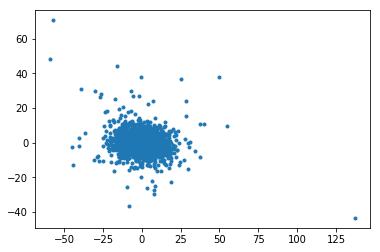

In [797]:
trans = pca.transform(normd)
plt.scatter(trans[:,0], trans[:,1], marker='.')

In [798]:
normd['pc1'] = trans[:,0]
normd['pc2'] = trans[:,1]
normd['pc3'] = trans[:,2]

In [837]:
m = statsmodels.formula.api.ols("B ~ pc1 + pc2", data=normd.rename(columns=dict((zip(normd.columns, "ABCEJ"))))).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      B   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 8.714e+04
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        10:18:41   Log-Likelihood:                -85684.
No. Observations:               95307   AIC:                         1.714e+05
Df Residuals:                   95304   BIC:                         1.714e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.444e-16      0.002   -7.5e-14      1.000      -0.004       0.004
pc1            0.2535      0.001    374.779      0.000       0.252       0.255
pc2            0.2157      0.001    183.906      0.000       0.213       0.218
==============================================================================
Omnibus:                    27250.298   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2040086.464
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                      25.648   Cond. No.                         2.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [838]:
normd['t'] = m.predict(normd[["pc1","pc2"]])

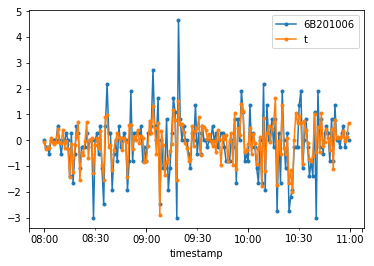

In [839]:
normd[["6B201006", "t"]].loc["2010-05-04 08":"2010-05-04 10"].plot(marker='.')

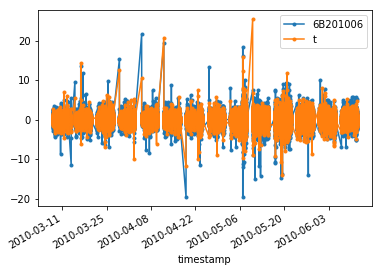

In [840]:
normd[["6B201006", "t"]].plot(marker='.')

In [824]:
m.predict(normd[["pc1","pc2","pc3"]]).head()

timestamp
2010-03-08 01:02:00   -0.632599
2010-03-08 01:03:00    0.286260
2010-03-08 01:04:00   -0.135345
2010-03-08 01:05:00    0.028152
2010-03-08 01:06:00    1.950580
dtype: float64

In [816]:
m = statsmodels.formula.api.ols("J ~ pc1 + pc2 + pc3", data=normd.rename(columns=dict((zip(normd.columns, "ABCEJ"))))).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      J   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.192e+06
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        10:13:35   Log-Likelihood:             1.2337e+05
No. Observations:               95307   AIC:                        -2.467e+05
Df Residuals:                   95303   BIC:                        -2.467e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.416e-17      0.000   3.45e-13      1.000      -0.000       0.000
pc1           -0.1643   7.54e-05  -2177.908      0.000      -0.164      -0.164
pc2            0.5066      0.000   3873.297      0.000       0.506       0.507
pc3            0.3706      0.000   1353.368      0.000       0.370       0.371
==============================================================================
Omnibus:                    30160.830   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2478075.705
Skew:                          -0.602   Prob(JB):                         0.00
Kurtosis:                      27.951   Cond. No.                         3.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using PCA reduction for regression

# EWMA commutes with .diff()

Calculating EWMA on a time-series and then the diff, has the same result as first calculating the diffs and then the EWMA on top of the diffs.

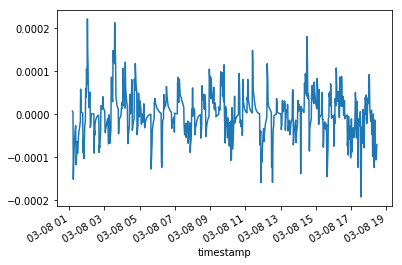

In [598]:
df.fillna(method="ffill")["6A201006"].ewm(span=10, min_periods=10).mean().diff()[:1000].plot()

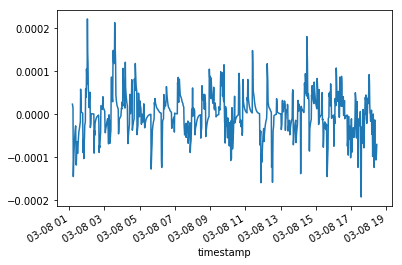

In [599]:
df.fillna(method="ffill")["6A201006"].diff().ewm(span=10, min_periods=10).mean()[:1000].plot()

In [596]:
pca = sklearn.decomposition.PCA()
pca.fit( normd.ewm(span=10, min_periods=10).mean().dropna() )

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [597]:
pca.explained_variance_ratio_

array([0.59977997, 0.16699802, 0.10497693, 0.06780058, 0.06044449])

In [619]:
pca.components_

array([[ 0.51505151,  0.42023404,  0.48049721,  0.4795311 , -0.31192573],
       [-0.05619116,  0.41531834, -0.08884081,  0.33204919,  0.84035937],
       [ 0.3404806 , -0.65030201,  0.53009613, -0.05302794,  0.42114888],
       [ 0.22429378, -0.44596723, -0.5594587 ,  0.65643197, -0.08311774],
       [-0.75188414, -0.17068846,  0.40894229,  0.47547699, -0.11056005]])

### Scatter plot in the original variables

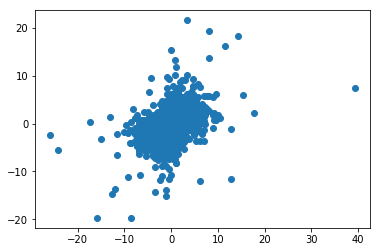

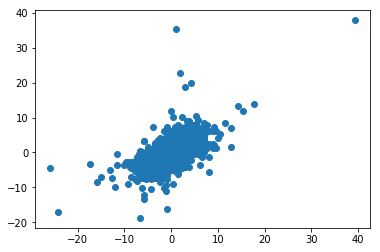

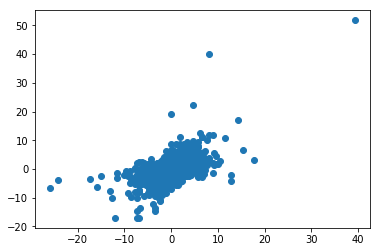

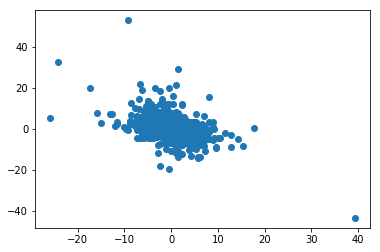

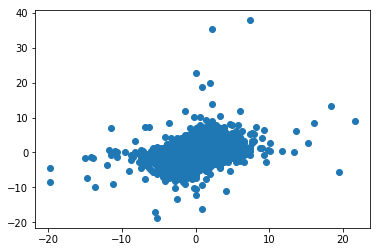

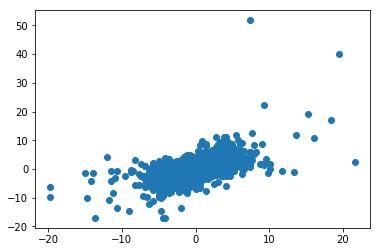

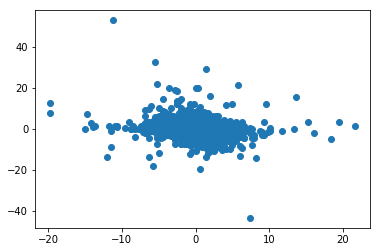

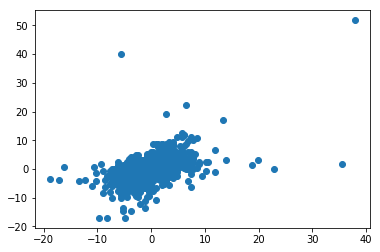

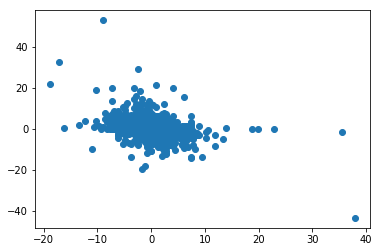

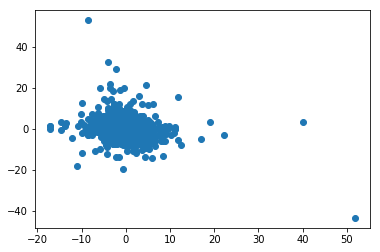

In [630]:
for (col1, col2) in itertools.combinations(normd.columns, 2):
    plt.scatter(normd[col1], normd[col2])
    plt.show()

### Scatter plot in the transformed variables

In [647]:
np.corrcoef(trans[:,1], trans[:,4])

array([[ 1.        , -0.01526463],
       [-0.01526463,  1.        ]])

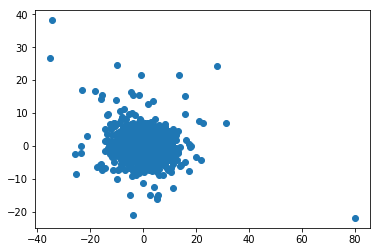

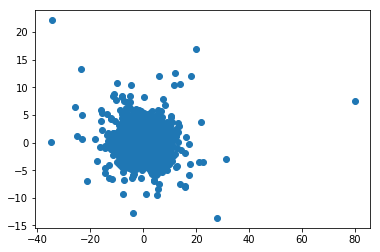

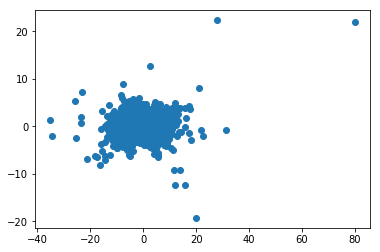

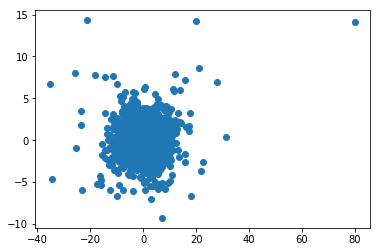

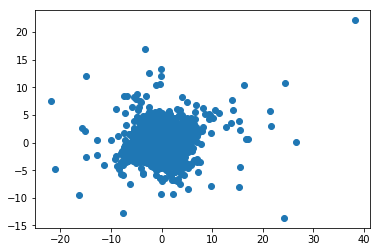

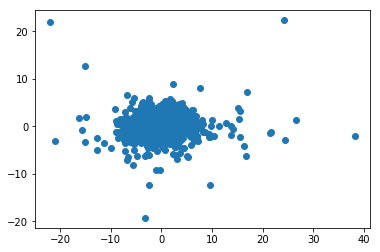

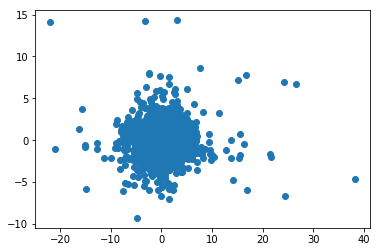

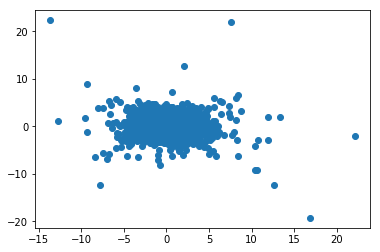

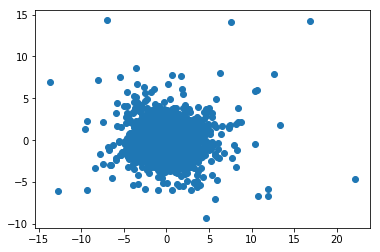

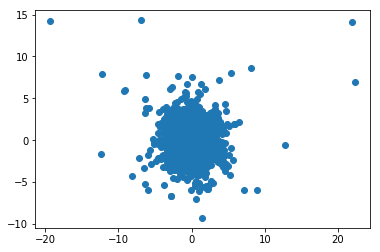

In [641]:
trans = pca.transform(normd)
for (col1, col2) in itertools.combinations(range(5), 2):
    plt.scatter(trans[:,col1], trans[:,col2])
    plt.show()

# Regressing one variable against the rest

In [786]:
statsmodels.formula.api.ols("A ~ B + C + E + J", data=normd.rename(columns=dict((zip(normd.columns, "ABCEJ"))))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                 2.209e+04
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        10:04:46   Log-Likelihood:            -1.0397e+05
No. Observations:               95307   AIC:                         2.080e+05
Df Residuals:                   95302   BIC:                         2.080e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.163e-15      0.002   4.98e-13      1.000      -0.005       0.005
B              0.1144      0.003     39.700      0.000       0.109       0.120
C              0.3504      0.003    124.612      0.000       0.345       0.356
E              0.3030      0.003     98.085      0.000       0.297       0.309
J             -0.1426      0.002    -58.221      0.000      -0.147      -0.138
==============================================================================
Omnibus:                    26062.570   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1864921.096
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      24.657   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [790]:
statsmodels.formula.api.ols("J ~ A + B + C + E", data=normd.rename(columns=dict((zip(normd.columns, "ABCEJ"))))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      J   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3366.
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        10:05:16   Log-Likelihood:            -1.2894e+05
No. Observations:               95307   AIC:                         2.579e+05
Df Residuals:                   95302   BIC:                         2.579e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.416e-17      0.003   2.45e-14      1.000      -0.006       0.006
A             -0.2408      0.004    -58.221      0.000      -0.249      -0.233
B             -0.0219      0.004     -5.809      0.000      -0.029      -0.015
C             -0.1578      0.004    -40.392      0.000      -0.165      -0.150
E              0.0276      0.004      6.563      0.000       0.019       0.036
==============================================================================
Omnibus:                    70668.380   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         70890785.070
Skew:                           2.214   Prob(JB):                         0.00
Kurtosis:                     136.536   Cond. No.                         2.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Changing frequency of data

It might be that some time scales are more relevant than others to find patterns. If this is the case then maybe changing the frequency of the data might increase the explained variance of the first PCs

In [401]:
pca = sklearn.decomposition.PCA()
pca.fit(normd)
display(pca.explained_variance_ratio_)

array([0.4958261 , 0.17964656, 0.13943254, 0.09815851, 0.08693629])

In [416]:
def diffnorm(df, freq=None):
    """ takes a DF, changes frequency, calculates diffs, normalizes """
    if freq is None:
        dffreq = df.fillna(method='ffill')
    else:
        dffreq = df.fillna(method='ffill').asfreq(freq)
    diffsfreq = dffreq.diff()
    normdfreq = (diffsfreq - diffsfreq.mean())/(diffsfreq.std())
    normdfreq = normdfreq[ ~(normdfreq.abs()>3) ].dropna(how="any")    
    return normdfreq

In [417]:
def pca_explained_var(df):
    """ just explanained_variance_ratio_ """
    pca = sklearn.decomposition.PCA()
    pca.fit(df)
    return pca.explained_variance_ratio_

## Superficially it appears that lower frequencies makes PCA more effective

In [428]:
display(pca_explained_var(diffnorm(df)))
display(pca_explained_var(diffnorm(df, freq="5min")))
display(pca_explained_var(diffnorm(df, freq="10min")))
display(pca_explained_var(diffnorm(df, freq="30min")))
display(pca_explained_var(diffnorm(df, freq="1H")))
display(pca_explained_var(diffnorm(df, freq="6H")))
display(pca_explained_var(diffnorm(df, freq="1D")))
display(pca_explained_var(diffnorm(df, freq="5D")))

array([0.4958261 , 0.17964656, 0.13943254, 0.09815851, 0.08693629])

array([0.55801054, 0.16917646, 0.1240395 , 0.07869854, 0.07007496])

array([0.57578352, 0.16957376, 0.11605571, 0.07463644, 0.06395058])

array([0.60045262, 0.15763301, 0.10743937, 0.07480807, 0.05966693])

array([0.61094039, 0.15439789, 0.10228383, 0.07696229, 0.0554156 ])

array([0.60642906, 0.15998876, 0.10294348, 0.08007968, 0.05055902])

array([0.63244814, 0.16919842, 0.09522414, 0.0693805 , 0.03374879])

array([0.71237795, 0.20451948, 0.05735751, 0.01921295, 0.00653211])

however these results are deceptive. Lower frequecy also implies fewer rows on the time-series, and it's easier to "explain variance" or equivalentely to overfit.

In [430]:
display(len(diffnorm(df)))
display(len(diffnorm(df, freq="5min")))
display(len(diffnorm(df, freq="10min")))
display(len(diffnorm(df, freq="30min")))
display(len(diffnorm(df, freq="1H")))
display(len(diffnorm(df, freq="6H")))
display(len(diffnorm(df, freq="1D")))
display(len(diffnorm(df, freq="5D")))

90518

17966

8968

2958

1452

248

52

7

For example, PCA on N random time-series should give explained variance of 1/N to each PC, but when the number of rows is smaller we can find that the PCA fit deviates significantely from this:

In [441]:
display(pca_explained_var(pd.DataFrame(np.random.randn(90518,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(17966,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(8968,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(2958,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(1452,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(248,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(52,5))))
display(pca_explained_var(pd.DataFrame(np.random.randn(7,5))))

array([0.20156312, 0.20084661, 0.19986402, 0.19933258, 0.19839367])

array([0.20677053, 0.20152542, 0.19991618, 0.19679876, 0.19498911])

array([0.20389696, 0.20333628, 0.20020449, 0.19751345, 0.19504882])

array([0.2111784 , 0.20653028, 0.19773035, 0.1944079 , 0.19015307])

array([0.21400549, 0.20743663, 0.20315025, 0.19418995, 0.18121767])

array([0.23785556, 0.21709518, 0.19792682, 0.19638669, 0.15073575])

array([0.28777114, 0.23101387, 0.20641681, 0.15376682, 0.12103135])

array([0.55137725, 0.37243864, 0.05027836, 0.01466102, 0.01124474])

So the fact that by increasing frequency we're icreasing explained var of the 1st is partly explained by the fact that we're simultaneously decreasing the number of data points.

However that's not the whole story either. With the random time-series, decreasing size from 90518 to 2958 only increased the explained var of the 1st PC from 0.20 to 0.21. On the other hand, on our futures data increasing frequency from "1min" to "30min" also reduces the number of data-points in the same way, but increases explained var from 0.49 to 0.60.

Two observations:
- One way to avoid these kind of problems is calculating PCA on a rolling or exponentially-weighted rolling basis.
- If we choose not to avoid the problem but instead understand it better, we have the questions: how many data-points do I need to believe anything that PCA tells us?, and what's the PCA error as a function of number of data-points?

# Playing with PCA example

`http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html`

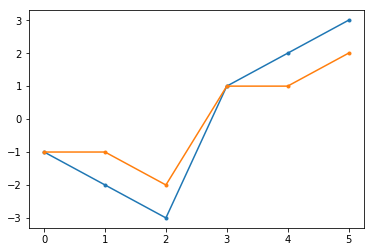

In [443]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
plt.plot(X, marker='.')

In [448]:
pca = sklearn.decomposition.PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### Not the same result as on the page

In [449]:
pca.explained_variance_

array([7.93954312])

In [450]:
pca.explained_variance_ratio_

array([0.99244289])

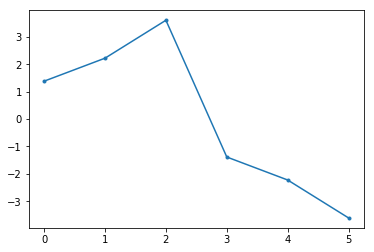

In [451]:
plt.plot(pca.transform(X), marker='.')

In [212]:
pca.components_

array([[-0.83849224, -0.54491354],
       [ 0.54491354, -0.83849224]])

In [213]:
pca.transform([[1,0]])

array([[-0.83849224,  0.54491354]])

In [170]:
pca.transform([[-1,-1],[-2, -1]])

array([[1.38340578],
       [2.22189802]])

In [174]:
X.mean(axis=0)

array([0., 0.])

In [176]:
pca.transform([[-1,-1],[-2, -1]])

array([[1.38340578],
       [2.22189802]])

In [180]:
pca.inverse_transform(  pca.transform([[-1,-1],[-2, -1]]) )

array([[-1.15997501, -0.75383654],
       [-1.86304424, -1.21074232]])

In [186]:
pca.transform([[1,0]])

array([[-0.83849224,  0.54491354]])

In [218]:
np.matmul( np.array([[-0.838,0.545],[-0.545,-0.838]]) , [[1],[0]] )

array([[-0.838],
       [-0.545]])

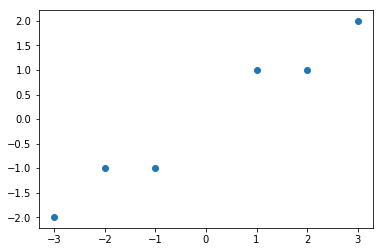

In [229]:
plt.scatter(X[:,0], X[:,1])

## n_components=1

In [219]:
pca = sklearn.decomposition.PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [220]:
pca.components_

array([[-0.83849224, -0.54491354]])

### N random series should have PCAs which explain 1/N of the variance each

In [309]:
t = sklearn.decomposition.PCA()
t.fit(np.random.randn(10000,5))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [310]:
t.explained_variance_ratio_

array([0.20756541, 0.20278478, 0.19833226, 0.19724216, 0.1940754 ])

In [252]:
normd[["6A201006","6C201006"]].corr()

,6A201006,6C201006
6A201006,1.00000,0.51097
6C201006,0.51097,1.00000


# Practicing PCA on iris dataset

Following `https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60`

In [718]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [719]:
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [720]:
from sklearn.preprocessing import StandardScaler

features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [721]:
pca = sklearn.decomposition.PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [722]:
principalDf.head()

,principal component 1,principal component 2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


In [723]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [724]:
finalDf.head()

,principal component 1,principal component 2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa


In [728]:
def scatter_features(df, feature1, feature2):

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(feature1, fontsize = 15)
    ax.set_ylabel(feature2, fontsize = 15)
    ax.set_title('{} and {}'.format(feature1, feature2), fontsize = 20)

    targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = df['target'] == target
        ax.scatter(df.loc[indicesToKeep, feature1]
                   , df.loc[indicesToKeep, feature2]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

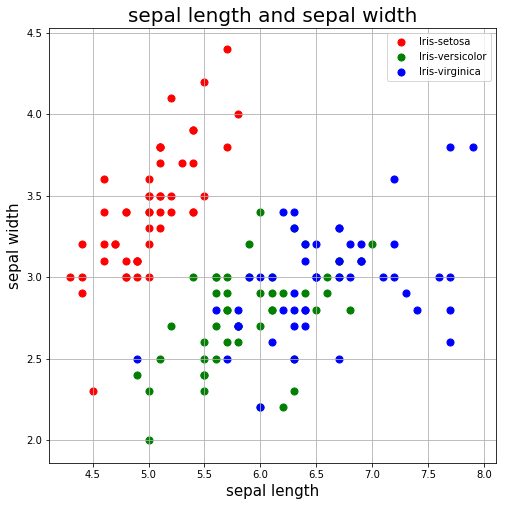

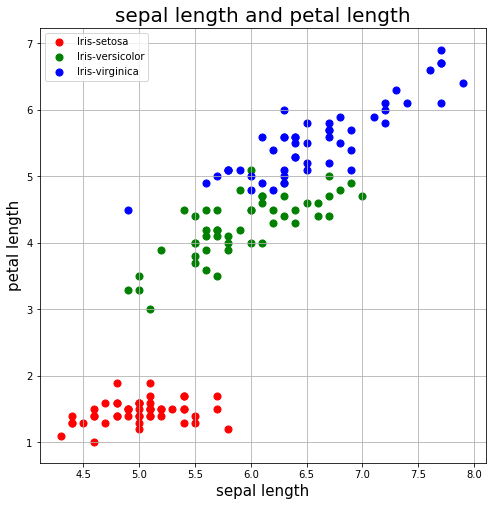

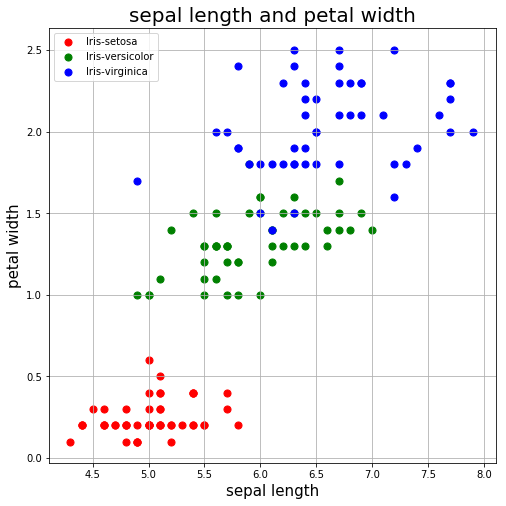

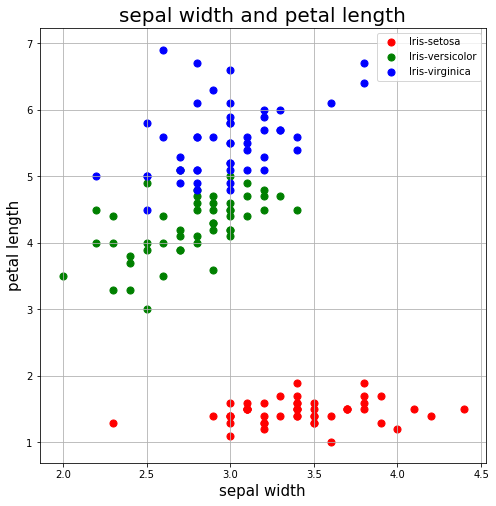

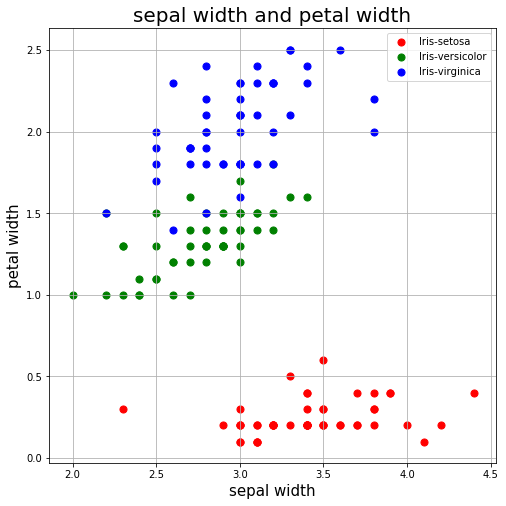

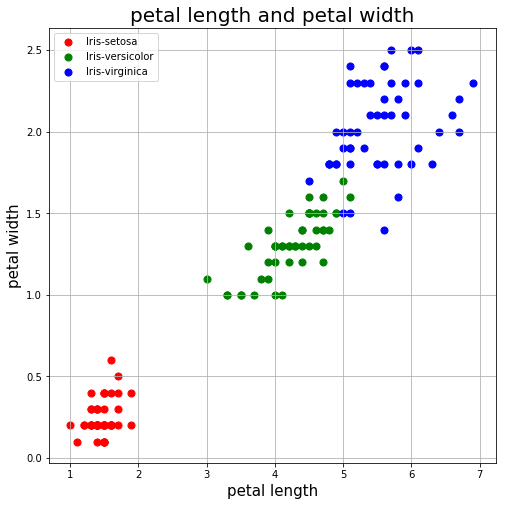

In [733]:
for (feature1, feature2) in itertools.combinations(df.columns[:4], 2):
    scatter_features(df, feature1, feature2)

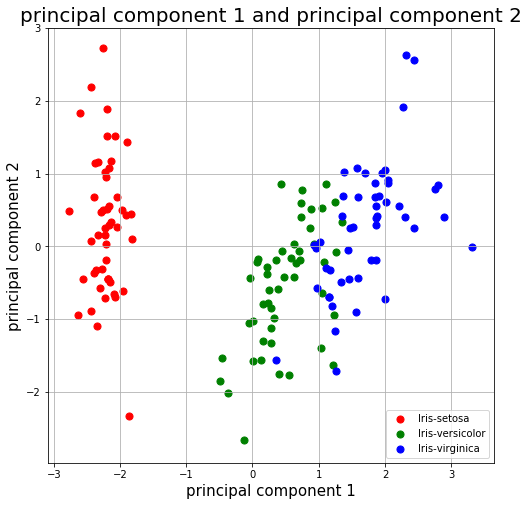

In [735]:
scatter_features(finalDf, "principal component 1", "principal component 2")

In [737]:
sum(pca.explained_variance_ratio_)

0.9580097536148198

# Simple PCA

Idea: If several time series are correlated, maybe we can use PCs as regression predictors. With two time-series (named A and B) and one PC, we regress one of the time-series against the PC. If the prediction of A deviates a lot from the observed value of A, maybe there's an opportunity.

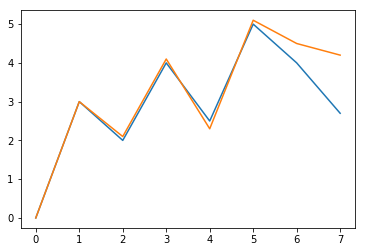

In [878]:
data = pd.DataFrame(np.array([[0,0],[3,3],[2,2.1],[4,4.1],[2.5,2.3],[5,5.1],[4,4.5],[2.7,4.2]]), columns=['A',"B"])
plt.plot(data)

In [879]:
pca = sklearn.decomposition.PCA(n_components=1)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [880]:
pca.explained_variance_ratio_

array([0.97374223])

In [881]:
data['pc'] = pca.transform(data)

#### Predict A

In [882]:
m = statsmodels.formula.api.ols("A ~ pc", data).fit()
m.summary()

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     184.7
Date:                Mon, 23 Apr 2018   Prob (F-statistic):           9.85e-06
Time:                        10:42:52   Log-Likelihood:               -0.35330
No. Observations:                   8   AIC:                             4.707
Df Residuals:                       6   BIC:                             4.865
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9000      0.103     28.089      0.000       2.647       3.153
pc            -0.6735      0.050    -13.590      0.000      -0.795      -0.552
==============================================================================
Omnibus:                       14.093   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.110
Skew:                          -1.738   Prob(JB):                       0.0777
Kurtosis:                       4.802   Cond. No.                         2.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

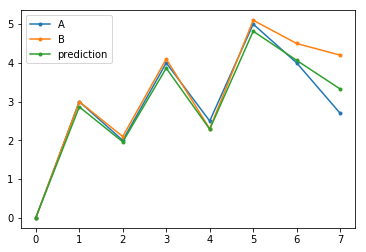

In [883]:
plt.plot(pd.DataFrame({"A":data['A'], "B":data['B'], "prediction":m.predict(data['pc'])}), marker='.')
plt.legend(["A","B","prediction"])

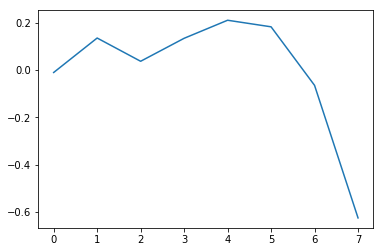

In [884]:
plt.plot(data["A"]-m.predict(data["pc"]))

#### Predict B

In [885]:
m = statsmodels.formula.api.ols("B ~ pc", data).fit()
m.summary()

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      B   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     268.1
Date:                Mon, 23 Apr 2018   Prob (F-statistic):           3.31e-06
Time:                        10:43:27   Log-Likelihood:                0.39206
No. Observations:                   8   AIC:                             3.216
Df Residuals:                       6   BIC:                             3.375
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1625      0.094     33.622      0.000       2.932       3.393
pc            -0.7392      0.045    -16.373      0.000      -0.850      -0.629
==============================================================================
Omnibus:                       14.093   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.110
Skew:                           1.738   Prob(JB):                       0.0777
Kurtosis:                       4.802   Cond. No.                         2.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

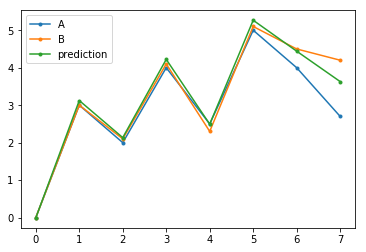

In [886]:
plt.plot(pd.DataFrame({"A":data['A'], "B":data['B'], "prediction":m.predict(data['pc'])}), marker='.')
plt.legend(["A","B","prediction"])

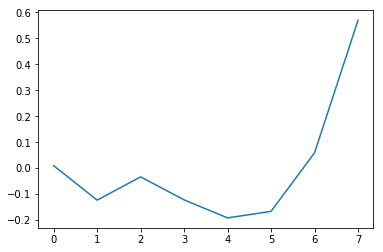

In [887]:
plt.plot(data["B"]-m.predict(data["pc"]))

### Actually, maybe we should be working on the diffs

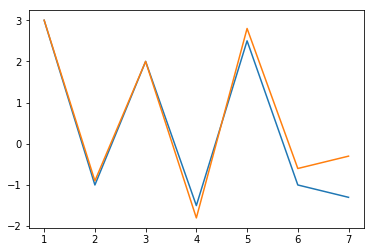

In [890]:
data = pd.DataFrame(np.array([[0,0],[3,3],[2,2.1],[4,4.1],[2.5,2.3],[5,5.1],[4,4.5],[2.7,4.2]]), columns=['A',"B"])
diffs = data.diff().dropna()
plt.plot(diffs)

In [891]:
pca = sklearn.decomposition.PCA(n_components=1)
pca.fit(diffs)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [899]:
diffs['pc'] = pca.transform(diffs)

In [902]:
m = statsmodels.formula.api.ols("A ~ pc", diffs).fit()
m.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     487.7
Date:                Mon, 23 Apr 2018   Prob (F-statistic):           3.53e-06
Time:                        10:47:18   Log-Likelihood:                 1.8002
No. Observations:                   7   AIC:                            0.3996
Df Residuals:                       5   BIC:                            0.2914
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3857      0.084      4.610      0.006       0.171       0.601
pc             0.7173      0.032     22.085      0.000       0.634       0.801
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.040
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.395
Skew:                          -0.581   Prob(JB):                        0.821
Kurtosis:                       2.930   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

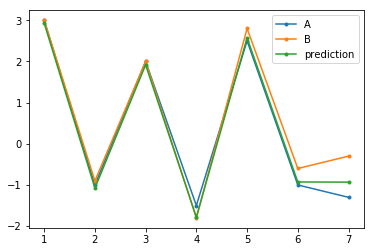

In [905]:
plt.plot(pd.DataFrame({"A":diffs['A'], "B":diffs['B'], "prediction":m.predict(diffs['pc'])}), marker='.')
plt.legend(["A","B","prediction"])

# Predicting diffs from PCs

## Model 1

- standardize diffs
- PCA with 1 component
- regress A,B,C,E,J against 1 PC


In [23]:
scaled_pca = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.PCA(n_components=1)
)

diffs = df.fillna(method="ffill").diff().dropna()
scaled_pca.fit(diffs)
diffs["pc"] = scaled_pca.transform(diffs)

In [24]:
scaled_pca.named_steps['pca'].explained_variance_ratio_

array([0.54071984])

In [25]:
for col in "ABCEJ":
    m = statsmodels.formula.api.ols("{} ~ pc".format(col),
                                    data=diffs,
                                   ).fit()
    diffs['prediction{}'.format(col)] = m.predict(diffs['pc'])

In [26]:
diffs.head()

,A,B,C,E,J,pc,predictionA,predictionB,predictionC,predictionE,predictionJ
timestamp,,,,,,,,,,,
2010-03-08 01:02:00,0.0004,0.0000,0.0,-0.0005,0.000000,-0.031657,-0.000005,-0.000006,-0.000004,-0.000006,2.330393e-08
2010-03-08 01:03:00,0.0008,0.0000,0.0,0.0002,-0.000001,1.989466,0.000260,0.000319,0.000232,0.000300,-1.533535e-06
2010-03-08 01:04:00,-0.0006,0.0000,0.0,-0.0001,0.000000,-1.324290,-0.000174,-0.000213,-0.000154,-0.000202,1.018999e-06
2010-03-08 01:05:00,0.0000,0.0000,0.0,0.0000,-0.000002,0.214560,0.000028,0.000034,0.000025,0.000031,-1.663530e-07
2010-03-08 01:06:00,-0.0001,0.0009,0.0,0.0001,0.000000,1.053461,0.000137,0.000168,0.000123,0.000158,-8.125452e-07


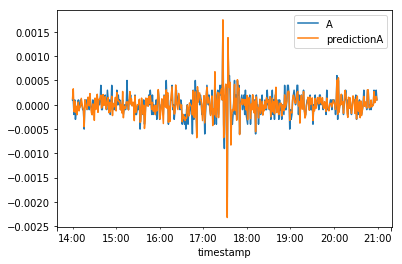

In [28]:
diffs[["A","predictionA"]].loc["2010-04-22 14":"2010-04-22 20"].plot()

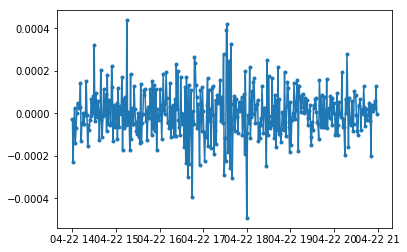

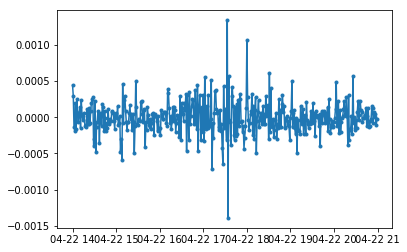

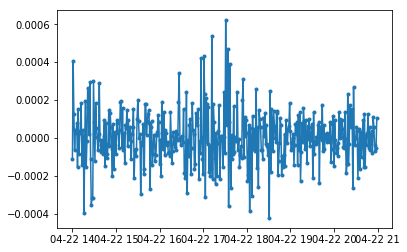

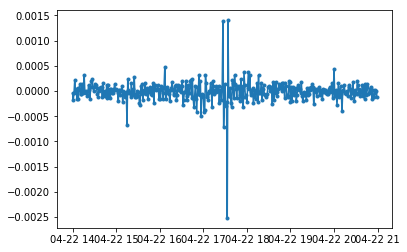

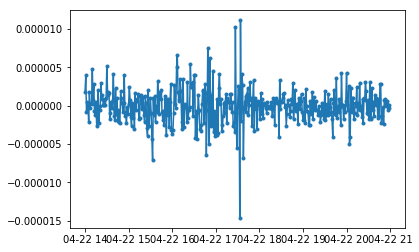

In [29]:
for col in "ABCEJ":
    plt.plot((diffs[col]-diffs['prediction{}'.format(col)]).loc["2010-04-22 14:00:00":"2010-04-22 20"], marker='.')
    plt.show()

## Model 2

- standardize diffs
- PCA with 2 component
- regress A,B,C,E,J against 2 PCs


In [30]:
scaled_pca = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.PCA(n_components=2)
)

diffs = df.fillna(method="ffill").diff().dropna()
scaled_pca.fit(diffs)
pcs = pd.DataFrame(scaled_pca.transform(diffs), columns=["pc1","pc2"], index=diffs.index)
diffs['pc1'] = pcs['pc1']
diffs['pc2'] = pcs['pc2']

In [31]:
scaled_pca.named_steps['pca'].explained_variance_ratio_

array([0.54071984, 0.1798338 ])

In [32]:
for col in "ABCEJ":
    m = statsmodels.formula.api.ols("{} ~ pc1 + pc2".format(col),
                                    data=diffs,
                                   ).fit()
    diffs['prediction{}'.format(col)] = m.predict(diffs[['pc1',"pc2"]])

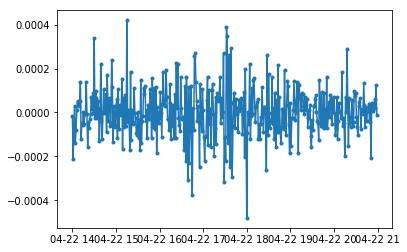

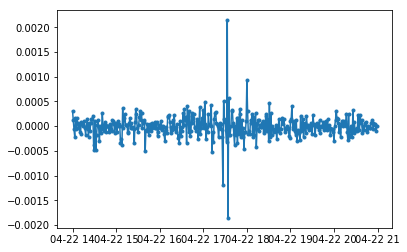

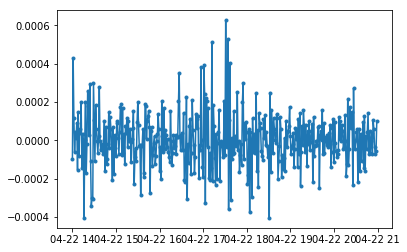

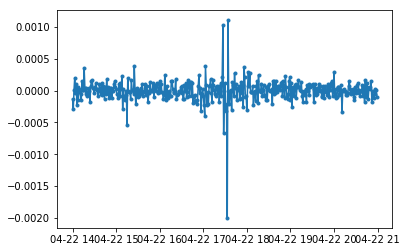

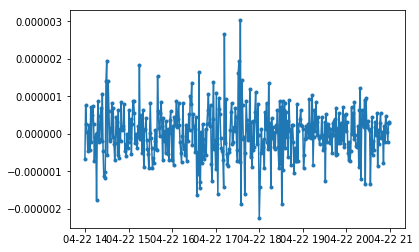

In [33]:
for col in "ABCEJ":
    plt.plot((diffs[col]-diffs['prediction{}'.format(col)]).loc["2010-04-22 14:00:00":"2010-04-22 20"], marker='.')
    plt.show()

### Improvement from adding one PC:

In [42]:
for col in "ABCEJ":
    m1 = statsmodels.formula.api.ols("{} ~ pc1".format(col), data=diffs).fit()
    m2 = statsmodels.formula.api.ols("{} ~ pc1 + pc2".format(col), data=diffs).fit()
    print("R^2 for {} prediction goes from {} to {}".format(col, m1.rsquared, m2.rsquared))

R^2 for A prediction goes from 0.6878955207808695 to 0.6898937542197956
R^2 for B prediction goes from 0.5210208677003276 to 0.6464787804186851
R^2 for C prediction goes from 0.6094924891218806 to 0.6140631440412897
R^2 for E prediction goes from 0.666329712601119 to 0.7412422892318347
R^2 for J prediction goes from 0.21886061016930314 to 0.9110902372144764


## Model 3

- standardize diffs
- PCA with 3 component
- regress A,B,C,E,J against 3 PCs


In [140]:
scaled_pca = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.PCA(n_components=3)
)

diffs = df.fillna(method="ffill").diff().dropna()
scaled_pca.fit(diffs)
pcs = pd.DataFrame(scaled_pca.transform(diffs), columns=["pc1","pc2","pc3"], index=diffs.index)
diffs['pc1'] = pcs['pc1']
diffs['pc2'] = pcs['pc2']
diffs['pc3'] = pcs['pc3']

In [141]:
scaled_pca.named_steps['pca'].explained_variance_ratio_

array([0.54071984, 0.1798338 , 0.12306906])

In [45]:
for col in "ABCEJ":
    m = statsmodels.formula.api.ols("{} ~ pc1 + pc2 + pc3".format(col),
                                    data=diffs,
                                   ).fit()
    diffs['prediction{}'.format(col)] = m.predict(diffs[['pc1',"pc2","pc3"]])

In [46]:
for col in "ABCEJ":
    m2 = statsmodels.formula.api.ols("{} ~ pc1 + pc2".format(col), data=diffs).fit()
    m3 = statsmodels.formula.api.ols("{} ~ pc1 + pc2 + pc3".format(col), data=diffs).fit()
    print("R^2 for {} prediction goes from {} to {}".format(col, m2.rsquared, m3.rsquared))

R^2 for A prediction goes from 0.6898937542197957 to 0.750007002338642
R^2 for B prediction goes from 0.6464787804186858 to 0.897056676724136
R^2 for C prediction goes from 0.61406314404129 to 0.8275239692846901
R^2 for E prediction goes from 0.7412422892318347 to 0.747923259434693
R^2 for J prediction goes from 0.9110902372144752 to 0.9956026089098255


In [49]:
scaled_pca.named_steps['pca'].components_

array([[ 0.50441743,  0.4389918 ,  0.47480253,  0.49644762, -0.2845199 ],
       [-0.0471414 ,  0.37353247, -0.07129656,  0.28864012,  0.87741373],
       [ 0.31255442, -0.63813407,  0.58897877, -0.10419822,  0.37059597]])

In [148]:
m = sklearn.linear_model.LinearRegression().fit(diffs[['pc1',"pc2","pc3"]], diffs["A"])
m.predict(diffs[['pc1',"pc2","pc3"]])

array([ 5.48471395e-05,  3.24805423e-04, -2.30017540e-04, ...,
        1.20582080e-06,  1.74653276e-04,  4.08615239e-05])

In [144]:
m = statsmodels.formula.api.ols("A ~ pc1 + pc2 + pc3", data=diffs).fit()
m.predict(diffs[['pc1',"pc2","pc3"]])

timestamp
2010-03-08 01:02:00    5.484714e-05
2010-03-08 01:03:00    3.248054e-04
2010-03-08 01:04:00   -2.300175e-04
2010-03-08 01:05:00    1.320338e-05
2010-03-08 01:06:00   -1.530488e-05
2010-03-08 01:07:00    2.364398e-05
2010-03-08 01:08:00    3.069474e-06
2010-03-08 01:09:00    1.443173e-04
2010-03-08 01:10:00   -1.647600e-05
2010-03-08 01:11:00   -2.402782e-05
2010-03-08 01:12:00   -3.477904e-05
2010-03-08 01:13:00   -3.661489e-08
2010-03-08 01:14:00   -3.381186e-04
2010-03-08 01:15:00    2.827387e-06
2010-03-08 01:16:00   -3.661489e-08
2010-03-08 01:17:00    9.020021e-05
2010-03-08 01:18:00   -6.628224e-05
2010-03-08 01:19:00   -1.865026e-05
2010-03-08 01:20:00   -2.651660e-05
2010-03-08 01:21:00   -1.279051e-06
2010-03-08 01:22:00   -5.341746e-05
2010-03-08 01:23:00   -1.151357e-04
2010-03-08 01:24:00   -1.420157e-04
2010-03-08 01:25:00   -9.030937e-05
2010-03-08 01:26:00   -1.047331e-05
2010-03-08 01:27:00   -2.606817e-04
2010-03-08 01:28:00   -4.442653e-05
2010-03-08 01:29:0

## Model 4

- standardize diffs
- run EWM on diffs
- Try PCA with 1,2,3 components
- regress A,B,C,E,J against PCs


In [149]:
diffs = df.fillna(method="ffill").diff().dropna()
#diffs = diffs.ewm(span=30, min_periods=30).mean().dropna()

In [117]:
scaled_pca = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.PCA(n_components=3)
)

scaled_pca.fit(diffs)
pcs = pd.DataFrame(scaled_pca.transform(diffs), columns=["pc1","pc2","pc3"], index=diffs.index)
diffs['pc1'] = pcs['pc1']
diffs['pc2'] = pcs['pc2']
diffs['pc3'] = pcs['pc3']

#### Compare R^2 from 1,2,3 PCs

In [118]:
d = {col:[] for col in "ABCEJ"}
for col in "ABCEJ":
    for i in (1,2,3):
        if i == 1:
            m = statsmodels.formula.api.ols("{} ~ pc1".format(col),
                                        data=diffs,
                                       ).fit()
        elif i == 2:
            m = statsmodels.formula.api.ols("{} ~ pc1 + pc2".format(col),
                                        data=diffs,
                                       ).fit()
        elif i == 3:
            m = statsmodels.formula.api.ols("{} ~ pc1 + pc2 + pc3".format(col),
                                        data=diffs,
                                       ).fit()
        d[col].append(m.rsquared)
        #print("col {} and {} components: R^2=={}".format(col, i, m.rsquared))
display(pd.DataFrame(d, index=(1,2,3)))

,A,B,C,E,J
1,0.763527,0.561056,0.708924,0.686762,0.339572
2,0.765903,0.723468,0.719296,0.785880,0.895361
3,0.826388,0.933801,0.849568,0.785926,0.991731


# Explore how the explained variance of the first PC varies over time and for different time scales

Create a rolling window of different sizes, run a rolling PCA, and keep the `explained_variance_ratio_` vector.

This still has the problem that obviously we'll find more variance "explained" in smaller datasets. For example, with `window_size=10` each PCA is fitted to only 10 datapoints, and the first PC frequently reaches 90% "explained" variance, spuriously no doubt.

In [139]:
# Takes a couple of minutes per time that `rolling_pca()` is called

def window(df, size):
    for i in range(len(df)-size+1):
        yield df.iloc[i:i+size]

def rolling_pca(window_size):
    diffs = df.fillna(method='ffill').diff().dropna()

    explained_var_ratio = []
    for n,w in enumerate(window(diffs, size=window_size)): ## 30-min window
        pca = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.decomposition.PCA(),
        )
        pca.fit(w)
        explained_var_ratio.append(pca.named_steps['pca'].explained_variance_ratio_)

    explained_var_ratio = pd.DataFrame(explained_var_ratio, index=diffs.index[window_size-1:])
    return explained_var_ratio

d = {}
for window_size in (10, 30, 60,6*60):
    #print(window_size)
    d[window_size] = rolling_pca(window_size)

for window_size in (10, 30, 60, 6*60):
    d[window_size].loc["2010-04-22"].plot(title="{}".format(window_size))
    plt.show()

10
30
60
360


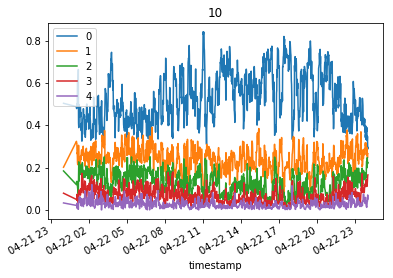

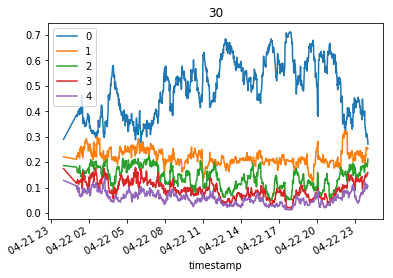

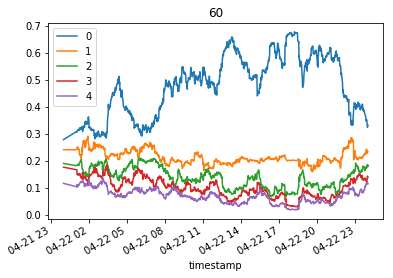

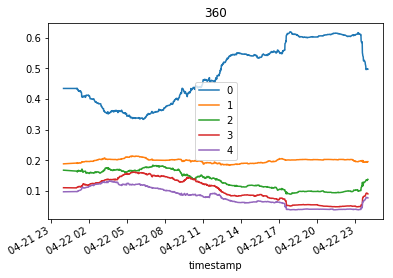

In [154]:
for window_size in (10, 30, 60, 6*60):
    d[window_size].loc["2010-04-22"].plot(title="{}".format(window_size))

# Explore how PCA varies when tick data is aggregated over different tick sizes.

The previous idea had the problem that by using a certain rolling window_size for PCA and comparing different window_sizes we're not just comparing dynamics at different time scales: there is the aditional factor that PCA over smaller datasets more easily fits noise.

Instead here we first aggregate ticks over a small certain tick size (say, 10 minutes) and then run the PCA over a certain rolling window size (say 30 ticks). Now we compare the results of different tick sizes while keeping the window size the same. This way we're removing the effect of different window sizes in the comparison

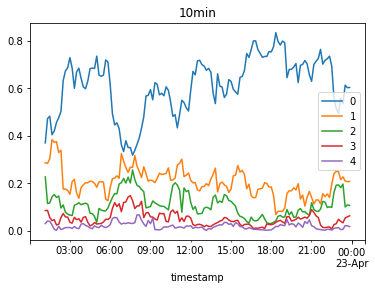

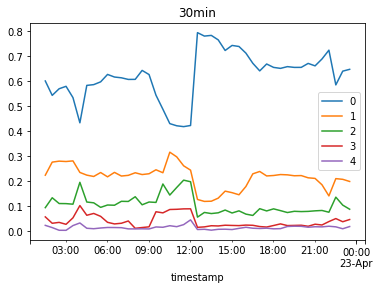

In [156]:
# Takes a couple of minutes per time that `rolling_pca()` is called

def window(df, size):
    for i in range(len(df)-size+1):
        yield df.iloc[i:i+size]

def rolling_pca(freq=None, window_size=None):
    
    if freq is None:
        diffs = df.fillna(method='ffill').diff().dropna()
    else:
        diffs = df.fillna(method='ffill').asfreq(freq).diff().dropna()

    explained_var_ratio = []
    for n,w in enumerate(window(diffs, size=window_size)): ## 30-min window
        pca = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.decomposition.PCA(),
        )
        pca.fit(w)
        explained_var_ratio.append(pca.named_steps['pca'].explained_variance_ratio_)

    explained_var_ratio = pd.DataFrame(explained_var_ratio, index=diffs.index[window_size-1:])
    return explained_var_ratio

d = {}
freqs = ("10min", "30min")
for freq in freqs:
    #print(window_size)
    d[freq] = rolling_pca(freq, window_size)

for window_size in freqs:
    d[window_size].loc["2010-04-22"].plot(title="{}".format(window_size))
    plt.show()

# Explore PCA on EWM data

Maybe there's no reason to ever change tick size. After all, that just loses us data.

Instead we keep the idea of making comparisons using fixed window size, but we use EWM over different spans.

In [197]:
def window(df, size):
    for i in range(len(df)-size+1):
        yield df.iloc[i:i+size]

def rolling_pca(ma=None, window_size=None):
    diffs = df.fillna(method='ffill').ewm(span=ma, min_periods=ma).mean().diff().dropna()
    
    explained_var_ratio = []
    for n,w in enumerate(window(diffs, size=window_size)): ## 30-min window
        pca = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),
            sklearn.decomposition.PCA(),
        )
        pca.fit(w)
        explained_var_ratio.append(pca.named_steps['pca'].explained_variance_ratio_)

    explained_var_ratio = pd.DataFrame(explained_var_ratio, index=diffs.index[window_size-1:])
    return explained_var_ratio

t = rolling_pca(ma=10, window_size=30)

d = {}
window_size = 30
spans = (10, 30, 60, 6*60)
for span in spans:
    #print(window_size)
    d[span] = rolling_pca(span, window_size)


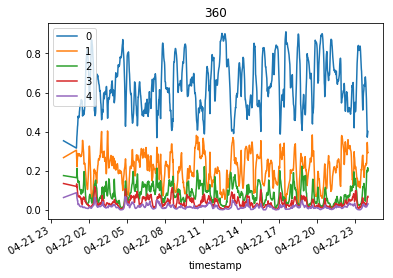

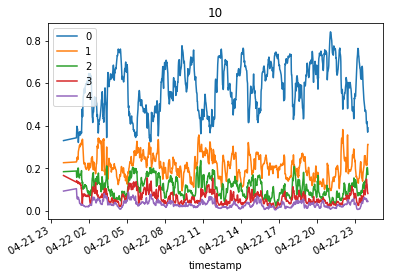

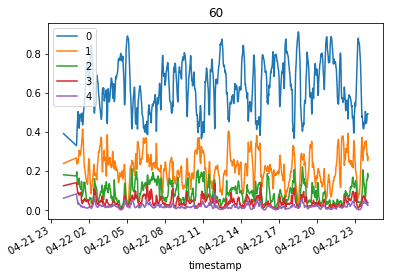

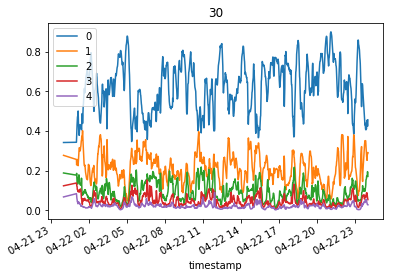

In [199]:
for span in d:
    d[span].loc["2010-04-22"].plot(title="{}".format(span))
    plt.show()

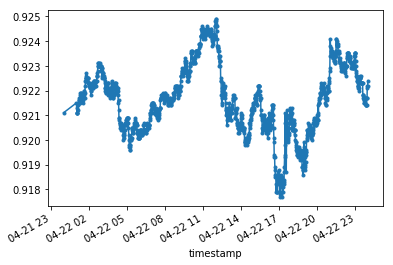

In [201]:
df.fillna(method='ffill').dropna().loc["2010-04-22", "A"].plot(marker='.')

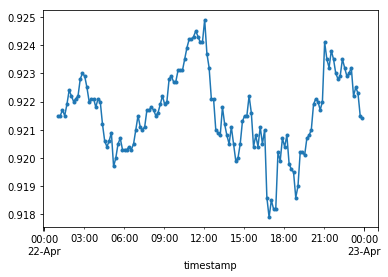

In [200]:
df.fillna(method='ffill').asfreq("10min").dropna().loc["2010-04-22", "A"].plot(marker='.')

## Superficially it appears that lower frequencies makes PCA more effective

## Model 5

- standardize diffs
- Try sparsePCA with 1,2,3 components
- regress A,B,C,E,J against PCs

In [231]:
sparse_pca = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.SparsePCA(n_components=3, alpha=1),
#    sklearn.decomposition.PCA(n_components=3),
#    sklearn.linear_model.LinearRegression(),
)

diffs = df.fillna(method='ffill').diff().dropna()
sparse_pca.fit(diffs[["A","B","C","E","J"]]) #, diffs["A"])
pcs = pd.DataFrame(sparse_pca.transform(diffs), index=diffs.index)

In [228]:
s = sparse_pca.named_steps['sparsepca']
s.components_

array([[-307.71831821,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
        -307.71831821],
       [   0.        ,  307.71831821,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        , -307.71831821,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,  307.71831821,
           0.        ]])

In [230]:
s = sparse_pca.named_steps['sparsepca']
s.components_

array([[-255.39823052, -229.26658894, -239.90162009, -257.09677485,
         127.96216124],
       [   0.        , -117.45154868,    7.2209405 ,  -94.74674402,
        -251.5953106 ]])

In [232]:
s = sparse_pca.named_steps['sparsepca']
s.components_

array([[-156.3222101 , -315.15570927, -107.11606992, -262.03428488,
           0.        ],
       [  24.3889743 ,    0.        ,    0.        ,  -21.9516858 ,
        -307.16099256],
       [-152.17717752,  120.03539261, -220.49861821,  -22.11415179,
           0.        ]])

In [37]:
sparse_pca.fit(diffs[["A","B","C","E","J"]])
sparse_pca.transform(diffs[["A","B","C","E","J"]])

array([[ 1.08778284e-03,  6.60988628e-04, -2.44546582e-03],
       [-2.84348481e-03,  1.70627566e-03, -4.98254972e-03],
       [ 1.89339374e-03, -4.26484055e-04,  3.76411426e-03],
       ...,
       [-1.83492271e-03,  9.73911152e-05,  1.83200169e-03],
       [ 2.39835380e-03,  2.09566453e-04, -6.79547123e-03],
       [ 8.74053131e-05, -6.44003798e-02, -1.19522486e-02]])

In [171]:
gs = sklearn.model_selection.GridSearchCV(pca_reg, dict(pca__n_components=[1,2,3]))
gs.fit(diffs[["A","B","C","E","J"]], diffs["A"])

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

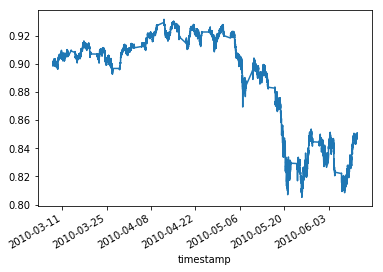

In [185]:
df.fillna(method="ffill")['A'].dropna().plot()

# Playing with FFT

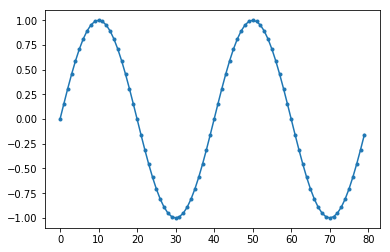

In [487]:
def f(x):
    return np.sin(x)

t = f(np.arange(0, 4*np.pi, np.pi/20))
plt.plot(t, marker='.')

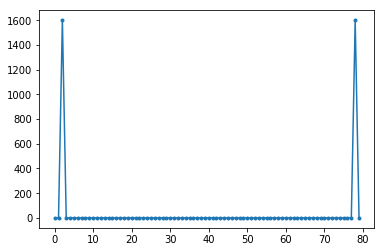

In [488]:
plt.plot(np.abs(np.fft.fft(t))**2, marker='.')

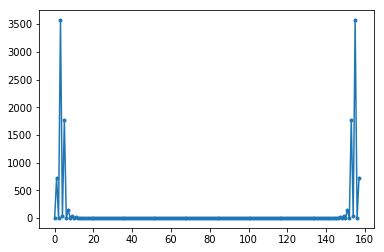

In [489]:
plt.plot(np.abs(np.fft.hfft(t))**2, marker='.')

/usr/local/lib/python3.5/dist-packages/scipy/signal/spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  .format(nperseg, input_length))


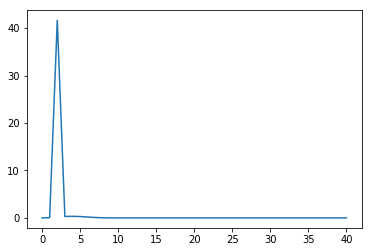

In [500]:
freqs, times, spectogram = scipy.signal.spectrogram(t)
plt.plot(spectogram)

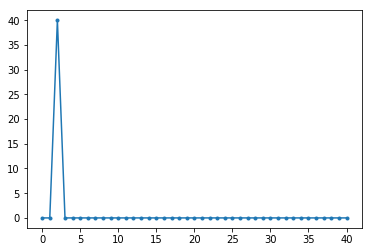

In [501]:
freqs,data = scipy.signal.periodogram(t)
plt.plot(data, marker='.')

/usr/local/lib/python3.5/dist-packages/scipy/signal/spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  .format(nperseg, input_length))


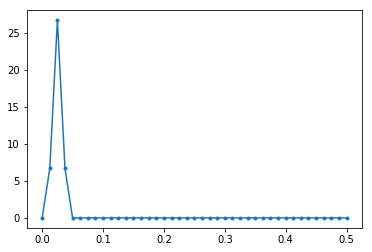

In [502]:
freqs,psd = scipy.signal.welch(t)
plt.plot(freqs, psd, marker='.')

#### Example of how to use `np.fft.fftfreq`

From `https://stackoverflow.com/questions/15382076/plotting-power-spectrum-in-python`

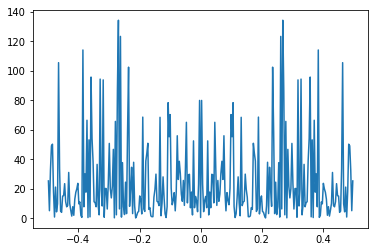

In [351]:
data = np.random.rand(301) - 0.5
ps = np.abs(np.fft.fft(data))**2

time_step = 1
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])

In [555]:
t = df.fillna(method="ffill")['A'].dropna()
t = t.loc["2010-04-07":"2010-04-09"]
#t.loc["2010-04-08 14":"2010-04-08"].plot()
display(len(t))

4137

In [538]:
#freqs, times, spectogram = scipy.signal.spectrogram(t)
#plt.plot(spectogram)

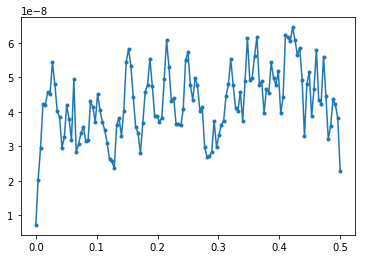

In [556]:
freqs, psd = scipy.signal.welch(t.diff().dropna())
plt.plot(freqs, psd, marker='.')

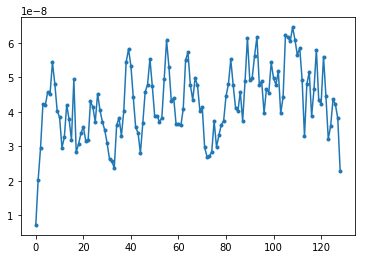

In [558]:
freqs, psd = scipy.signal.welch(t.diff().dropna())
plt.plot(psd, marker='.')

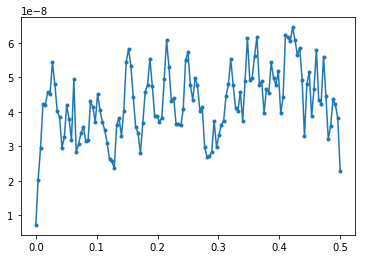

In [557]:
freqs, psd = scipy.signal.welch(t.diff().dropna())
plt.plot(freqs, psd, marker='.')

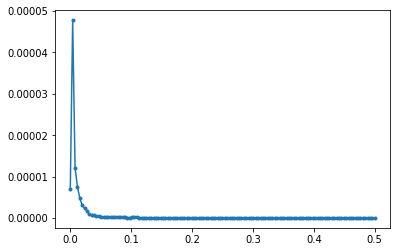

In [553]:
freqs, psd = scipy.signal.welch(t)
plt.plot(freqs, psd, marker='.')

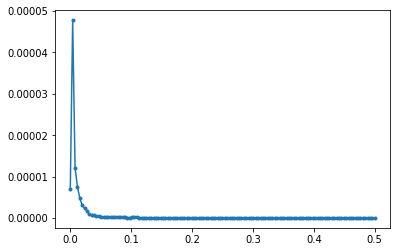

In [552]:
freqs, psd = scipy.signal.welch(t-t.mean())
plt.plot(freqs, psd, marker='.')

In [526]:
len(psd)

129

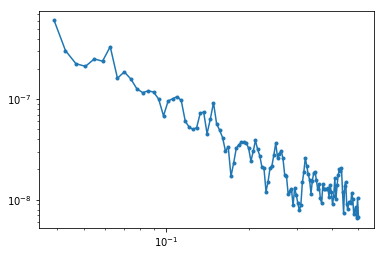

In [513]:
plt.loglog(freqs[10:], psd[10:], marker='.')

# Playing with sparse PCA

# A summary of sklearn's functions

## Decomposition
(`http://scikit-learn.org/stable/modules/decomposition.html#decompositions`)

- PCA
- IncrementalPCA (PCA in batches, used for many rows)
- PCA with randomized SVD (aproximation, used for many dimensions)
- KernelPCA (use non-linear kernel)
- SparsePCA and MiniBatchSparsePCA
- Truncated Singular Value Decomposition (SVD) don't really understand it, seems to be used in NLP
- Dictionary Learning don't really understand it, seems to be used in NLP
- Factor Analysis (generalization of PCA. the article above defines factor analysis as a probabilistic model, which makes comparison with PCA more difficult)
- Independent components analysis (used to separate mixed signals)
- Non-Negative Matrix factorization (only works for non-negative "data matrices"?!)
- Latent Dirichlet Allocation (LDA) (generative probabilistic model, seems specific for text)

## Regression
(`http://scikit-learn.org/stable/supervised_learning.html#supervised-learning`)

- `LinearRegression` - Ordinary Least Squares
- `Ridge` - Ridge Regression, like OLS with a penalty on the weights (euclidean length)
- `Lasso` - like OLS with L1 penalty - prefers fewer parameters
- `MultiTaskLasso` - like Lasso, sparse coefficients. However, which (sparse) set of predictors get picked might depend on the sample
- `ElasticNet` - OLS with both L1 and L2 penalties
- `MultiTaskElasticNet`
- `Lars`, `LassoLars` - Least Angle Regression. use for high dimensional data
- `OrthogonalMatchingPursuit` (OMP) - like OLS, but constrained number of non-zero coefficients


# Model

- normalise
- factor analysis

In [264]:
diffs = df.fillna(method='ffill').diff().dropna()

norm_factor = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.FactorAnalysis(n_components=2),
)

norm_factor.fit(diffs)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('factoranalysis', FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=2,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01))])

In [265]:
norm_factor.named_steps['factoranalysis'].components_

array([[ 0.75634133,  0.63500509,  0.67096663,  0.86367124, -0.31934299],
       [-0.30635323,  0.1067633 , -0.27735568,  0.24408276,  0.28649169]])

In [263]:
norm_factor.named_steps['factoranalysis'].components_

array([[ 0.78144211,  0.65727623,  0.70072331,  0.79140874, -0.35297707],
       [-0.20211747,  0.29266532, -0.2128692 ,  0.20969671,  0.2945829 ],
       [ 0.03091767, -0.12879547,  0.06372397,  0.0529816 ,  0.23513299]])

In [280]:
norm_factor = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.decomposition.FactorAnalysis(n_components=2),
#    sklearn.linear_model.LinearRegression()
)


In [281]:
norm_factor.fit(diffs, diffs["A"])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('factoranalysis', FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=2,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01))])

In [292]:
t = pd.DataFrame(norm_factor.transform(diffs), index=diffs.index, columns=['f1','f2'])
t['A'] = diffs['A']
statsmodels.formula.api.ols("A ~ f1 + f2", 
                            data=t,
                           ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      A   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 2.744e+05
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:51:34   Log-Likelihood:             7.4273e+05
No. Observations:               95307   AIC:                        -1.485e+06
Df Residuals:                   95304   BIC:                        -1.485e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.194e-07   3.23e-07     -1.606      0.108   -1.15e-06    1.15e-07
f1             0.0002   3.45e-07    647.201      0.000       0.000       0.000
f2            -0.0002   4.74e-07   -360.489      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    27915.298   Durbin-Watson:                   2.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3131384.368
Skew:                          -0.324   Prob(JB):                         0.00
Kurtosis:                      31.073   Cond. No.                         1.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Procrustes

`https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html#scipy.linalg.orthogonal_procrustes`

`https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2276632`
